# Exploratory Data Analysis and Data Preprocessing




### Prepare and review data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


DATA_PATH = "/content/drive/My Drive/Data/complaints.csv"

# Load the dataset
df = pd.read_csv(DATA_PATH)

# Preview the dataset
print("Dataset shape:", df.shape)
df.head()

# Basic info
print("\n--- Dataset Info ---")
df.info()

# Check missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Unique values in key columns
print("\n--- Unique Products ---")
print(df['Product'].value_counts())

# Sample narratives
print("\n--- Sample Narratives ---")
print(df['Consumer complaint narrative'].dropna().sample(5, random_state=42).values)


/tmp/ipython-input-1-3201688290.py:10: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Dataset shape: (9609797, 18)

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int

### Filtering and Cleaning

In [ ]:
product_mapping = {
    "credit card": "Credit card",
    "credit card or prepaid card": "Credit card",

    "consumer loan": "Personal loan",
    "payday loan, title loan, or personal loan": "Personal loan",
    "payday loan, title loan, personal loan, or advance loan": "Personal loan",

    "checking or savings account": "Savings account",

    "money transfers": "Money transfers",
    "money transfer, virtual currency, or money service": "Money transfers"
}

# Standardize product names (lowercase & strip)
df['Product'] = df['Product'].str.strip().str.lower()

# Apply mapping
df['Mapped_Product'] = df['Product'].map(product_mapping)

# Keep only mapped products
filtered_df = df[df['Mapped_Product'].notnull()].copy()

# Drop rows with missing or empty narratives
filtered_df = filtered_df[filtered_df['Consumer complaint narrative'].notnull()]
filtered_df = filtered_df[filtered_df['Consumer complaint narrative'].str.strip() != ""]

print("Filtered dataset shape:", filtered_df.shape)
print(filtered_df['Mapped_Product'].value_counts())


Filtered dataset shape: (463933, 19)
Mapped_Product
Credit card        189334
Savings account    140319
Money transfers     98685
Personal loan       35595
Name: count, dtype: int64


###  Analyze Narrative Lengths

count    463933.000000
mean        205.036303
std         227.137225
min           1.000000
25%          82.000000
50%         136.000000
75%         254.000000
max        6469.000000
Name: narrative_word_count, dtype: float64


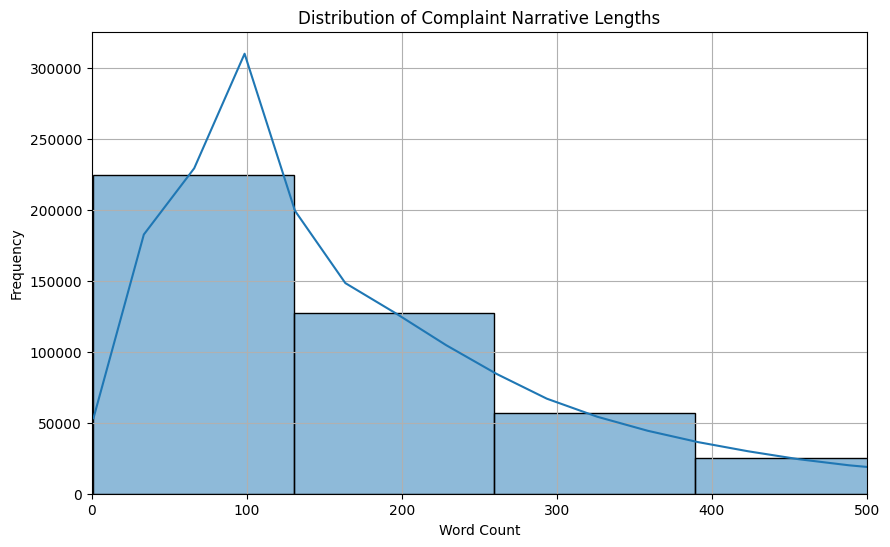


🔹 Very short complaints (<20 words): 11641
🔸 Very long complaints (>300 words): 89355


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute word count
filtered_df["narrative_word_count"] = filtered_df["Consumer complaint narrative"].apply(lambda x: len(str(x).split()))

# Summary stats
print(filtered_df["narrative_word_count"].describe())

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["narrative_word_count"], bins=50, kde=True)
plt.title("Distribution of Complaint Narrative Lengths")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.xlim(0, 500)  # Focus on most common range
plt.grid(True)
plt.show()

# Count short and long complaints
very_short = filtered_df[filtered_df["narrative_word_count"] < 20]
very_long = filtered_df[filtered_df["narrative_word_count"] > 300]

print(f"\n🔹 Very short complaints (<20 words): {very_short.shape[0]}")
print(f"🔸 Very long complaints (>300 words): {very_long.shape[0]}")


### Clean Narratives

In [ ]:
import re

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove boilerplate phrases (can add more as needed)
    boilerplate_patterns = [
        r"^i am writing to (file|submit) a complaint.*?\.",
        r"^i would like to (file|submit) a complaint.*?\.",
        r"^this is a complaint about.*?\.",
        r"^dear (cfpb|consumer financial protection bureau).*?\.",
        r"^to whom it may concern.*?\.",
        r"^complaint id.*?\n",
        r"^i am reaching out regarding.*?\.",
        r"^i am contacting you because.*?\.",
        r"^please be advised that.*?\.",
        r"^i have a concern about.*?\.",
        r"^i am submitting this complaint because.*?\.",
        r"^i want to report an issue with.*?\.",
        r"^i am filing this complaint to.*?\.",
        r"^i recently filed a complaint.*?\.",
        r"^this letter is in regard to.*?\.",
        r"^i am writing in regard to.*?\.",
        r"^i am writing to express my concern.*?\.",
        r"^i am writing to inform you.*?\.",
        r"^i am writing regarding.*?\.",
        r"^i am submitting this complaint against.*?\.",
        r"^i am writing to formally file.*?\.",
        r"^i sent a letter regarding.*?\.",
                               ]

    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # Remove non-alphanumeric characters (except basic punctuation)
    text = re.sub(r"[^a-z0-9\s\.,!?']", ' ', text)

    # Normalize whitespace
    text = re.sub(r"\s+", ' ', text).strip()

    return text

# Apply cleaning
filtered_df["cleaned_narrative"] = filtered_df["Consumer complaint narrative"].apply(clean_text)

# Drop very short narratives (<20 words) if desired
final_df = filtered_df[filtered_df["narrative_word_count"] >= 20].copy()

print("Final dataset shape after cleaning and filtering short complaints:", final_df.shape)


Final dataset shape after cleaning and filtering short complaints: (452292, 21)


### Save Cleaned Dataset

In [ ]:
output_path = "/content/drive/My Drive/Data/filtered_complaints.csv"
final_df.to_csv(output_path, index=False)